In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import random
import networkx as nx
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

## Utils

In [2]:
#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065/3
def pairwise_distances(x, y=None, w=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is None:
        y = x
        y_t = y.t()
        y_norm = x_norm
    if w is not None:
        x = x * w    
        y = y * w    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)


def file2graph(fn='./facebook/0.edges'):
    with open(fn) as f:
        lines = [l.split()[:2] for l in f.readlines()]
        edges = [tuple(int(i) for i in l) for l in lines]
        nodes = set(sum(edges, ())) ## SLOW?
#         edges += [(-1, n) for n in nodes]
#         nodes.update({-1})
    G = nx.Graph()
    G.add_nodes_from(list(nodes))
    G.add_edges_from(edges)
    return G


def dict2tensor(d, fill=None):
    n = len(d.keys())
    k2i = {k:i for i,k in enumerate(sorted(d.keys()))}
    res = torch.zeros(len(d.keys()), len(d.keys()), device=device)
    for src_node, dst_nodes in d.items():
        for dst_node, distance in dst_nodes.items():
            if fill is not None:
                res[k2i[src_node],k2i[dst_node]] = fill
            else:
                res[k2i[src_node],k2i[dst_node]] = distance
    return res, k2i

## Optimization Procedures

In [3]:
# def stress_minimization(X, D, Adj, optimizer, max_iter=10):
#     def stress(x, d, adjacency):
#         pdist = pairwise_distances(x)
#         s = ((pdist - d)**2).mean()
#         return s

#     for i in range(max_iter):
#         s = stress(X, D, Adj)
#         s.backward()
#         optimizer.step()
#         X.grad.data.fill_(0)
#     return X, s

In [4]:
def neighbor_preservation_bce(X, Adj, optimizer, max_iter=10, w=None):
    
    sigmoid = nn.Sigmoid()
    neighborSizes = Adj.sum(dim=1).int()
    nodeCount = Adj.shape[0]
    
    def euclidean_neighbor(x):
        pdist = pairwise_distances(x, w=w)
        res = torch.zeros([x.shape[0],x.shape[0]], device=device)
        for i, [distances, ns] in enumerate(zip(pdist, neighborSizes)):
#             print(distances.shape, nodeCount, ns.item())
            topk = distances.topk(nodeCount-ns.item())
            thresh = topk.values[-2:].mean()
            scale = 2.0
            res[i,:] = 1-sigmoid((distances-thresh) * scale)
        return res

    bce = nn.BCELoss()
    for i in range(max_iter):
        pred = euclidean_neighbor(X)
        truth = Adj
        eye = torch.eye(pred.shape[0], device=device)
        pred *= (1-eye)
        loss = bce(pred, truth)
        loss.backward()
        optimizer.step()
        X.grad.data.fill_(0)
        
    return X, loss, pred



def neighbor_preservation(X, Adj, optimizer, max_iter=10, w=None):
    
    sigmoid = nn.Sigmoid()
    neighborSizes = Adj.sum(dim=1).int()
    nodeCount = Adj.shape[0]

    def model(x):
        pdist = pairwise_distances(x, w=w)
        res = pdist.max() - pdist
        return res

    jaccard_loss = lovasz(hingeError) #option 3 (slow and does not work as expected)

    for i in range(max_iter):
        pred = model(X)
        truth = Adj
        eye = torch.eye(pred.shape[0], device=device)
        pred *= (1-eye)
        loss = jaccard_loss(pred.view(-1), truth.view(-1))
        loss.backward()
        optimizer.step()
        X.grad.data.fill_(0)
    
    return X, loss, pred


relu = nn.ReLU()
def hingeError(pred, target):
    pred = pred*2-1
    target = target*2-1
    return relu(1-pred*target)/2


def jaccardIndex(pred, target):
    intersect = pred*target
    union = (pred+target).clamp(0,1)
    j = intersect.sum() / union.sum()
    return j


def lovasz(error_func=hingeError):
    def jaccardLoss(error, target):
        union = (error+target).clamp(0,1)
        return error.sum() / union.sum()
    
    def f(pred, target):
        error = error_func(pred, target)
        sorted_error = torch.sort(error)
        values, indices = sorted_error.values, sorted_error.indices
        loss = 0
        for i in range(values.shape[0], 0, -1):
            error0 = error.clone()
            error1 = error.clone()
            error1[indices[:i-1]] = 0
            error1[indices[i-1:]] = 1
            error0[indices[:i]] = 0
            error0[indices[i:]] = 1
            weight = values[i-1]
            margin = (jaccardLoss(error1, target) - jaccardLoss(error0, target)).detach()
            loss += weight * margin
        return loss
    return f

## test:
pred   = torch.tensor([1.0, 0, 0, 0, 1, 1], requires_grad=True)
target = torch.tensor([1.0, 0 ,0, 0, 1, 1])
f = lovasz()
print('jaccard index:', jaccardIndex(pred, target).item())
print(' jaccard loss:', 1-jaccardIndex(pred, target).item())
print('  lovasz loss:', f(pred, target))

jaccard index: 1.0
 jaccard loss: 0.0
  lovasz loss: tensor(0., grad_fn=<AddBackward0>)


## generate a graph

In [5]:
%%time

print('generating graph...')
# G = nx.path_graph(10)
G = nx.cycle_graph(10)
# G = nx.balanced_tree(2,4)
# G = nx.connected_watts_strogatz_graph(10,5,0.5)
# G = file2graph('./facebook/0.edges')

print('calculating all pairs shortest path...')
D,k2i = dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
Adj,_ = dict2tensor(dict(G.adjacency()), fill=1)

generating graph...
calculating all pairs shortest path...
CPU times: user 3.18 s, sys: 985 ms, total: 4.17 s
Wall time: 4.16 s


## Optimize via Stochastic Gradient Descent (SGD)

In [23]:
!rm -r fig
!mkdir fig

In [26]:
X = torch.randn(len(G.nodes), 2, requires_grad = True, device=device)

# stress_optimizer = optim.SGD([X], lr=0.01)
neighbor_optimizer = optim.SGD([X], lr=0.03)
lossHistory = []

# def schedule(i, n):
#     return np.exp(-i/n*2)
# niter = 200
# i=np.linspace(0, niter, niter+1)
# plt.plot(i, schedule(i, niter))

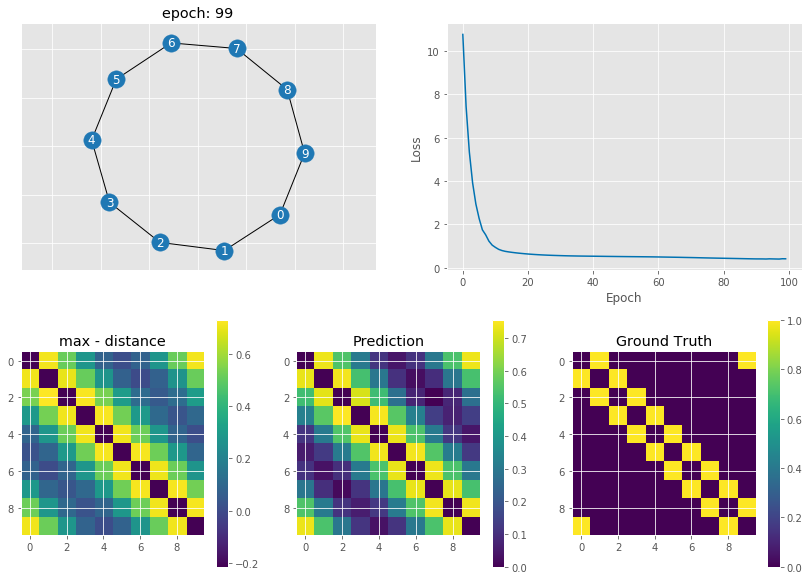

In [27]:
niter = 100
for i in tqdm(range(niter)):
    
    ## option 1: stress minimization
#     X, stress = stress_minimization(X, D, Adj, stress_optimizer, max_iter=10)

    ## option 2: neighbor preservation
#     w = torch.tensor([1.0, 1.0, schedule(i, niter), schedule(i, niter)], device=device)
    X, loss, pred = neighbor_preservation(X, Adj, neighbor_optimizer, max_iter=5, w=None)
    
    ## debug & vis
    lossHistory.append(loss.item())
    if i%20==19:
        print(loss.item())
        x = X.detach().cpu().numpy()
        
        display.clear_output(wait=True)
        plt.figure(figsize=[14, 10])

        ## graph
        plt.subplot(221)
        nx.draw_networkx(G, pos={k: x[k2i[k],:2] for k in G.nodes}, font_color='white')
        plt.axis('equal')
        plt.title('epoch: {}'.format(i))

        ## loss
        plt.subplot(222)
        plt.plot(lossHistory)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')


        ## pred vs truth
        plt.subplot(234)
#         pdist = pairwise_distances(X)
#         pdist = pdist / pdist.max(dim=1, keepdim=True).values
#         pdist = pdist.detach().cpu()
#         plt.imshow(1-pdist)
        pdist = pairwise_distances(X)
        pdist = pdist.detach().cpu()
        plt.imshow(pdist.max()-pdist-np.eye(pdist.shape[0]))
        plt.title('max - distance')
        plt.colorbar()

        plt.subplot(235)
        plt.imshow(pred.detach().cpu())
        plt.title('Prediction')
        plt.colorbar()
        
        plt.subplot(236)
        plt.imshow(Adj.detach().cpu())
        plt.colorbar()
        plt.title('Ground Truth')
        
        plt.savefig(f'fig/epoch{i}.png')
        plt.show()